In [1]:
import ROOT
from pathlib import Path
import lzt_utils as lu
import mplhep
import matplotlib.pyplot as plt
import awkward  as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logging
import tqdm
lu.utils.set_logger()
ROOT.EnableImplicitMT()
plt.style.use(mplhep.style.ATLAS)

Module libc not found.


# Loading Data

In [2]:
evt_num = 1213
evt_num_col = 'EventInfoContainer_Events.eventNumber'
lzt_data = Path('/', 'root', 'ext_data', 'lorenzetti')
dataset_name = '2024_08_20_21_08_0000000000_zee'
dataset_path = lzt_data / dataset_name
output_dir = lzt_data / 'analysis' / dataset_name / f'event_{evt_num:08d}'
output_dir.mkdir(exist_ok=True, parents=True)
dataset = lu.dataset.LztDataset.from_dir(dataset_path)
dataset

LztDataset(path=/root/ext_data/lorenzetti/2024_08_20_21_08_0000000000_zee, label=Z->ee)

In [3]:
aod_rdf = dataset.get_aod_rdf()
max_evt_num = aod_rdf.Max("EventInfoContainer_Events.eventNumber").GetValue()
min_evt_num = aod_rdf.Min("EventInfoContainer_Events.eventNumber").GetValue()
print(f'Event Number range is {min_evt_num} - {max_evt_num}')

Event Number range is 3.0 - 103167.0


In [4]:
aod_rdf.Describe()

Dataframe from TChain CollectionTree in file /root/ext_data/lorenzetti/2024_08_20_21_08_0000000000_zee/AOD/zee.AOD.root

Property                Value
--------                -----
Columns in total           99
Columns from defines        0
Event loops run             2
Processing slots           10

Column                                          Type                                            Origin
------                                          ----                                            ------
CaloCellContainer_Cells                         ROOT::VecOps::RVec<xAOD::CaloCell_t>            Dataset
CaloCellContainer_Cells.descriptor_link         ROOT::VecOps::RVec<Int_t>                       Dataset
CaloCellContainer_Cells.deta                    ROOT::VecOps::RVec<Float_t>                     Dataset
CaloCellContainer_Cells.dphi                    ROOT::VecOps::RVec<Float_t>                     Dataset
CaloCellContainer_Cells.e                       ROOT::VecOps::RVec<Float_t> 

In [5]:
aod_chain = dataset.get_aod_tchain()
event = None
for entry in aod_chain:
    if entry.EventInfoContainer_Events[0].eventNumber == evt_num:
        event = entry
        break

# Plot Cell Pulses

 48%|████▊     | 457/960 [01:53<02:05,  4.01it/s]


KeyboardInterrupt: 

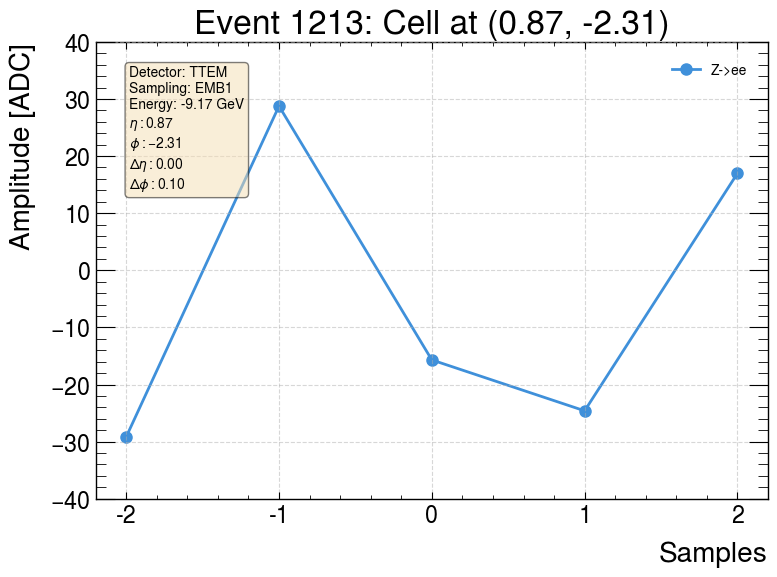

In [6]:
for cell in tqdm.tqdm(event.CaloDetDescriptorContainer_Cells):
    # logging.info(f'Cell: {cell.detector}, {cell.sampling}, {cell.eta:.2f}, {cell.phi:.2f}')
    fig, ax = plt.subplots()
    ax.grid(alpha=0.5, linestyle='--')
    pulse = np.array(cell.pulse)
    half_len = len(pulse) // 2
    x = np.arange(-half_len, half_len+1)
    ax.plot(x, pulse, label=dataset.label,
            marker='o')
    detector_name = lu.detector.Detector(cell.detector).name
    sampling_name = lu.detector.CaloSampling(cell.sampling).name
    ax.set(
        xlabel='Samples',
        ylabel='Amplitude [ADC]',
        title=f'Event {evt_num}: Cell at ({cell.eta:.2f}, {cell.phi:.2f})',
        xticks=x,
        xlim=1.1*x[[0, -1]],
    )
    ax.set_xticklabels([str(i) for i in x])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textstr = '\n'.join([
        f'Detector: {detector_name}',
        f'Sampling: {sampling_name}',
        f'Energy: {cell.e:.2f} GeV',
        fr'$\eta: {cell.eta:.2f}$',
        fr'$\phi: {cell.phi:.2f}$',
        fr'$\Delta\eta: {cell.deta:.2f}$',
        fr'$\Delta\phi: {cell.dphi:.2f}$',
    ])
    ax.text(0.05, 0.95, textstr, fontsize=10,
        verticalalignment='top', bbox=props,
        transform=ax.transAxes)
    ax.legend(fontsize=10)
    fig.tight_layout()
    fig.savefig(output_dir / f'individual_cell_pulse_{detector_name}_{sampling_name}_{cell.eta:.2f}_{cell.phi:.2f}.png')
    plt.close(fig)
    # break

# Calo Activity Plot

In [15]:
hist_args = (
    'calo_map',
    f'Calo map for event {evt_num}',
    100, -1.6, 1.6,
    100, float(-np.pi), float(np.pi)
)
calo_map_rdf = dataset.get_esd_rdf() \
    .Filter(f'{evt_num_col}[0] == {evt_num}')
max_energy = calo_map_rdf.Max('CaloCellContainer_Cells.e').GetValue()
min_energy = calo_map_rdf.Min('CaloCellContainer_Cells.e').GetValue()
calo_map_hist = calo_map_rdf \
    .Histo2D(hist_args,
             'CaloCellContainer_Cells.eta',
             'CaloCellContainer_Cells.phi',
             'CaloCellContainer_Cells.e').GetValue()

In [ ]:
canvas = ROOT.TCanvas('calo_map_canvas', 'Calo Map', 1100, 800)
calo_map_hist.SetMinimum(1e-6)
calo_map_hist.SetMaximum(max_energy*1.1)
calo_map_hist.SetStats(0)
calo_map_hist.Draw('colz')
canvas.Draw()